<h1>Project: NLP with disaster tweets</h1>
<p><b>Author: </b>Sebastian Gomez Ahumada</p>

<p>In this project, we are going to build a classifier for disaster tweets in order to identify wheter a tweet is about a real disaster or not.</p>
<p><b>Link: </b>https://github.com/gomez2608/nlp_tweets_kaggle.git</p>

In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction, preprocessing, model_selection
import keras.layers as ly
import visualkeras
from IPython.display import display
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
import os,glob
from keras.utils import text_dataset_from_directory


In [2]:
train_data = pd.read_csv("train.csv")
display(train_data[:5])

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


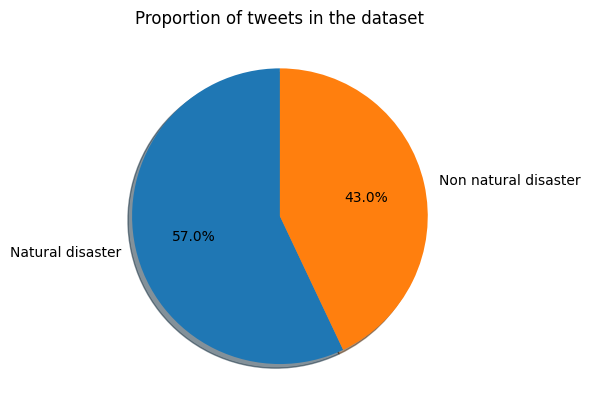

In [3]:
description = train_data["target"].value_counts()
print(description)
plt.figure()
plt.title("Proportion of tweets in the dataset")
plt.pie(description,labels=["Natural disaster",'Non natural disaster'],autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()


<p>As we can see, the 57% of the tweets are indicating a natural disaster while the 43% are not; in order to work with tweets, we are going to tokenize the data (count each one of the unique words on 
each tweet and vectorize it); for this, we are going to organize the dataset into a folder with two subfolders (one for each class)</p>

In [7]:
#We make the new folder and subfolders
os.mkdir("train")
os.mkdir(os.path.join("train","0"))
os.mkdir(os.path.join("train","1"))

#We filter the tweets according to their target and save them into separated .txt files
positive_class = train_data[train_data["target"] == 1]
for each_tweet in range(len(positive_class["text"])):
    with open(os.path.join("train","1",f"tweet_{each_tweet}.txt"),"w",encoding="UTF-8") as handle:
        handle.write(train_data["text"][each_tweet])
        handle.close()


negative_class = train_data[train_data["target"] == 0]
for each_tweet in range(len(negative_class["text"])):
    with open(os.path.join("train","0",f"tweet_{each_tweet}.txt"),"w",encoding="UTF-8") as handle:
        handle.write(train_data["text"][each_tweet])
        handle.close()

<p>Now, we are going to represent each tweet according to his tokens; in other words, we are going to represent a tweet according to the words that compose it into a numerical array</p>

In [4]:
tokenize_train_example = feature_extraction.text.CountVectorizer().fit_transform(train_data["text"][:2])

print("Example of a tokenize tweet:")
print(f'Tweet: {train_data["text"][0]}\t\t Tokenized tweet: {tokenize_train_example[0].todense()}')

Example of a tokenize tweet:
Tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all		 Tokenized tweet: [[1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1]]


<p>Now, we are going to load the dataset using the aux function from tensorflow </p>

In [5]:
batch_size = 32

train_ds, valid_ds = text_dataset_from_directory("train",batch_size=32,seed=42,validation_split=0.2,subset="both")

Found 7613 files belonging to 2 classes.
Using 6091 files for training.
Using 1522 files for validation.


<p>We define the model and vectorize the tweets with a text vectorization layer (preprocessing) in order to adequate it to the model, the model architecture is based on the keras example's of NLP processing with modifications such as batch normalization and dropout, also, I include a LSTM layer because it is useful for NLP and work with texts</p>

In [6]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
import keras.layers as layers

learning_rate = 0.01

max_features = 11000
embedding_dim = 32

batch_size = 32

vector_layer = ly.TextVectorization(max_features,output_mode="int",output_sequence_length=500)
train_text = train_ds.map(lambda x,y: x)
vector_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vector_layer(text), label

train_ds = train_ds.map(vectorize_text)
valid_ds = valid_ds.map(vectorize_text)

def model_def():
    model = Sequential()
    model.add(ly.Embedding(max_features,16))
    model.add(ly.BatchNormalization())
    model.add(ly.Dropout(0.2))
    model.add(ly.LSTM(64))
    model.add(ly.BatchNormalization())
    model.add(ly.Dropout(0.2))
    model.add(ly.Dense(16, activation='relu'))
    model.add(ly.BatchNormalization())
    model.add(ly.Dropout(0.2))
    model.add(ly.Dense(1))
    model.compile(Adam(learning_rate),BinaryCrossentropy(),BinaryAccuracy())
    return model

model = model_def()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          176000    
                                                                 
 batch_normalization (BatchN  (None, None, 16)         64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [8]:
#We define functions in order to plot metrics

def plot_acc(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [9]:
#We train the model, it is only necessary 3 epochs because after that all the trainings gave the same loss and metrics

epochs = 3
history = model.fit(train_ds,validation_data=valid_ds,epochs = epochs)

Epoch 1/3
191/191 [==============================] - 102s 487ms/step - loss: 5.1526 - binary_accuracy: 0.5278 - val_loss: 3.0201 - val_binary_accuracy: 0.4363
Epoch 2/3
191/191 [==============================] - 105s 550ms/step - loss: 1.9035 - binary_accuracy: 0.5093 - val_loss: 1.4124 - val_binary_accuracy: 0.5637
Epoch 3/3
191/191 [==============================] - 102s 533ms/step - loss: 1.0213 - binary_accuracy: 0.5500 - val_loss: 0.7082 - val_binary_accuracy: 0.5637


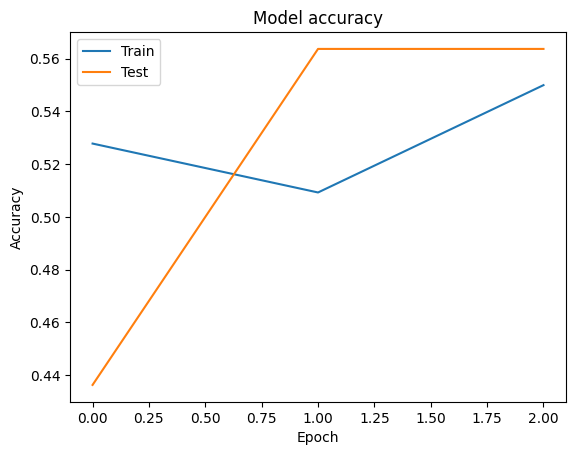

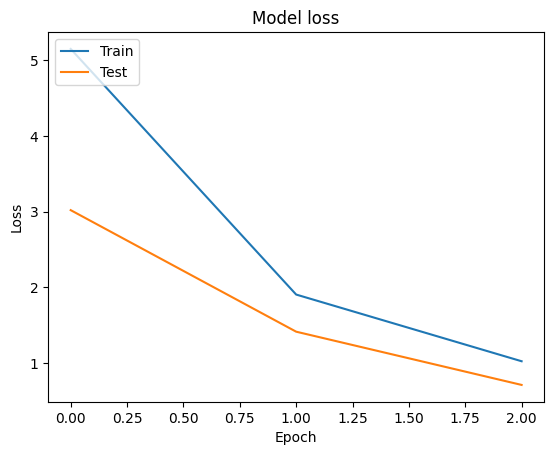

In [10]:
plot_acc(history)
plot_loss(history)

In [81]:
#Now we reorganize the test file into several txt files 
os.mkdir("test")
handle = pd.read_csv("test.csv")
for each_tweet in range(len(handle["text"])):
    with open(os.path.join("test",f"tweet_{each_tweet+1}.txt"),"w",encoding="UTF-8") as han:
        han.write(handle["text"][each_tweet])
        han.close()

In [12]:
model.save("model.tf",save_format="tf")

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


In [77]:
#we load the test dataset and vectorize it

def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return vector_layer(text)

test_ds = text_dataset_from_directory("test",batch_size=batch_size,labels=None,label_mode=None)

Found 3263 files belonging to 1 classes.


In [78]:
test_ds = test_ds.map(vectorize_text)

In [79]:
#Now we predict over the model

predictions = model.predict(test_ds)

102/102 [==============================] - 10s 97ms/step


In [85]:
#We report the predictions over the texts according with the kaggle format and approximating the output 

data_predictions = pd.DataFrame.from_dict({"id":handle["id"],"target":predictions.flatten()})
data_predictions["target"] = data_predictions["target"].map(lambda x: 0 if x<0.5 else 1)

In [86]:
data_predictions.to_csv("predictions.csv",index=False)

<p>In conclusion, we developt a simple NLP model for classifying tweets with a LSTM layer, some improvements can include a better vectorization method of the tweets and a decay of the learning rate </p>